# Introduction 
This program is a neuronal newtork which can increase (7 by 7) images to (28 by 28) while keeping the global shape described by the starting image.

First we have to import all the libraries that we need


In [0]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim
from torch.optim import lr_scheduler
from skimage.measure import block_reduce
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

This cell allows to dowload the MNIST dataset. 
We apply a modification on the content by the transform "mnist_transform" which is a transformation of all images to tensors. That is these tensors that we will use to train our model.

Then we create two dataloader :

*   The first one, train_loader is made from the train dataset of MNIST.
*   The second one, test_loader is made from the test dataset of MNIST.

Our train_loader and test_loader are composed by batchs of 32 images .

In [0]:
mnist_transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = datasets.MNIST(root = '../data', train = True, download = True, transform = mnist_transform)
test_dataset = datasets.MNIST(root = '../data', train = False, download = True, transform = mnist_transform)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


The following cell creates a dataset composed by minimized images (From 28x28 to 7x7) by using an average pooling operation on our train and test datasets (based on the FashionMNIST dataset) to keep the global shape of the pattern on each image. 

Then we initialise two loader based on our new datasets, new_train_dataset and new_test_dataset.

In [3]:
def get_minimized_dataset(dataset):
  new_dataset = []
  for i_data in range(len(dataset)):
    new_dataset.append([])
    new_dataset[i_data].append(torch.tensor([block_reduce(dataset[i_data][0][0], block_size = (4,4), func=np.mean)]))
    new_dataset[i_data].append(dataset[i_data][0])
  return new_dataset

new_train_dataset = get_minimized_dataset(train_dataset)
new_test_dataset = get_minimized_dataset(test_dataset)

new_train_loader = DataLoader(new_train_dataset, batch_size = 32, shuffle = True)
new_test_loader = DataLoader(new_test_dataset, batch_size = 32, shuffle = True)

This class defines a convolutional block which will be implemented in our model.
By default this block does not changes the input size and a relu activation function is applied.

In [0]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, act = F.relu):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels  = in_channels, #number of incoming chanels (3 for an image)
            out_channels = out_channels, #number of outputing chanels
            kernel_size  = kernel_size, #kernel size
            stride       = stride,  #how many pixels the kernel is moving
            padding      = padding, #number of pixel out of the frame
        )
        self.act = act

    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        return x

This class defines a convolutional upsample which will be usefull to increase by 2 the size of our images in our neuronal network.

In [0]:
class ConvUpsample(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, padding = 0):
        super(ConvUpsample, self).__init__()   
        self.conv = nn.Upsample(scale_factor = 2, mode='bilinear', align_corners=False)
        #Different way to divided an image size by 2
        #self.conv = nn.ConvTranspose2d(intput_size, output_size, kernel_size, stride, padding, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')    
        #self.act = F.relu 

    def forward(self, x):
        x = self.conv(x)
        #x = self.act(x)
        return x

The goal of our model is to increase the resolution of a given image while increase the quality of the pattern described by the image.

This model is composed by several convolution layer and performs two increase operation (from 7 * 7 to 14 * 14 and from 14 * 14 to 28 * 28).

It uses some dropout to avoid dataset memorizing from model.

In [0]:
class SuperResolutionModel(nn.Module):
    def __init__(self):
        super(SuperResolutionModel, self).__init__()

        self.seq = nn.Sequential(
            ConvUpsample(),
            ConvBlock(1, 128),
            ConvBlock(128, 128),
            nn.Dropout(p=0.2),
            ConvBlock(128, 64),
            ConvUpsample(),
            ConvBlock(64, 64),
            nn.Dropout(p=0.1),
            ConvBlock(64, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 1, act = nn.Sigmoid())
        )

    def forward(self, x):
        return self.seq(x)

This method allows to train our model. It calculates a prediction, and adjust the weights according to the result.

At each epoch we call the evaluation function to know the model accuracy.

In [0]:
def train(model, criterion, optimizer, epochs, trainloader, testloader, device, scheduler): 
    model.train()
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        eval_loss  = evaluate(model, criterion, device, testloader, 20)
        print(f' Eval : loss {eval_loss:6.7f} 'f'\n')
        for batch_id, (X, y) in enumerate(trainloader): #X = data given to the model for predictions , y = the expected result
            X, y = X.to(device), y.to(device) #64 images 28x28
            optimizer.zero_grad() #cleans the optimizer
            y_pred = model(X) #gets the model prediction
            loss   = criterion(y_pred, y) #calculates the prediction loss
            loss.backward() #updates the weights to make future predictions closer to what we want 
            optimizer.step() #notifies the optimizer that we did a step 
        scheduler.step() #decreases the learning rate

This method goal is to evaluate the model accuracy. For each batch in the loader,
it calculates the model prediction on an element and use the criterion for calculate the gap between the prediction and the desired result. This result is added to the loss.
When n_batch have been calculated, the method shows 4 images :

*   The first one is the image that has been given to the model.
*   The second one is the desired image.
*   The last one is the image made by the model.


Finally the function returns the average loss of all predictions.

In [0]:
def evaluate(model, criterion, device, loader, n_batch = -1):
    model.eval() 
    losses = 0
    total_pred = 0
    figure = plt.figure()
    with torch.no_grad():
      for batch_id, (X, y) in enumerate(loader):
            X = X.to(device)
            y = y.to(device)
            if (batch_id == n_batch):
              figure.add_subplot(1, 3, 1)
              plt.imshow(X[0][0].cpu().detach(), cmap = 'gray')
              figure.add_subplot(1, 3, 2)
              plt.imshow(y[0][0].cpu().detach(), cmap = 'gray')
              figure.add_subplot(1, 3, 3)
              plt.imshow(model(X)[0][0].cpu().detach(), cmap = 'gray')
              plt.show()
              return losses / total_pred
            y_pred = model(X)
            losses += criterion(y_pred, y)
            total_pred  += len(y)

In [0]:
def main():
    epochs        = 5 #number of detabase iteration
    learning_rate = 1e-3 #sets the starting learning rate
    device = torch.device('cuda') #sets the device to the GPU
    model = SuperResolutionModel() #creates the neuronal network
    model = model.to(device) #sets the model in the device
    optimizer     = optim.Adagrad( params = model.parameters(), lr = learning_rate )#setting the optimizer algorithm with wich update neuronal weights
    scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)#the scheduler is used to update the learning rate gradually
    criterion     = nn.MSELoss() #sets the loss function
    train(model, criterion, optimizer, epochs, new_train_loader, new_test_loader, device, scheduler)
    return

Epoch 1/5
----------


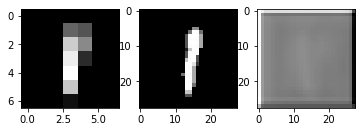

 Eval : loss 0.0071927 

Epoch 2/5
----------


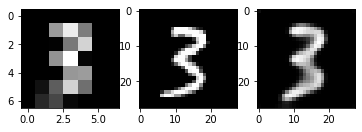

 Eval : loss 0.0005669 

Epoch 3/5
----------


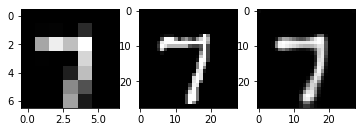

 Eval : loss 0.0004992 

Epoch 4/5
----------


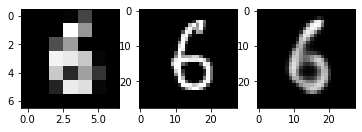

 Eval : loss 0.0004865 

Epoch 5/5
----------


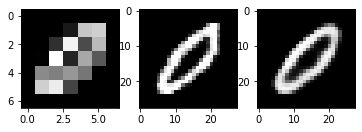

 Eval : loss 0.0004703 



In [10]:
main()